<a href="https://colab.research.google.com/github/hiydavid/homl-learning/blob/main/tryouts/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST with TensorFlow

---
# Load libraries & data

In [1]:
# load libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras

# check version
print('matplotlib v.', mpl.__version__)
print('numpy v.', np.__version__)
print('pandas v.', pd.__version__)
print('sklearn v.', sklearn.__version__)
print('tensorflow v.', tf.__version__)
print('keras v.', keras.__version__)

matplotlib v. 3.2.2
numpy v. 1.19.5
pandas v. 1.1.5
sklearn v. 0.22.2.post1
tensorflow v. 2.5.0
keras v. 2.5.0


In [2]:
# load mnist and split into train/test
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# check shapes
print(X_train_full.shape, y_train_full.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [3]:
# train-validation-test splits and rescale inputs to between 0 and 1
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

# check shapes
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


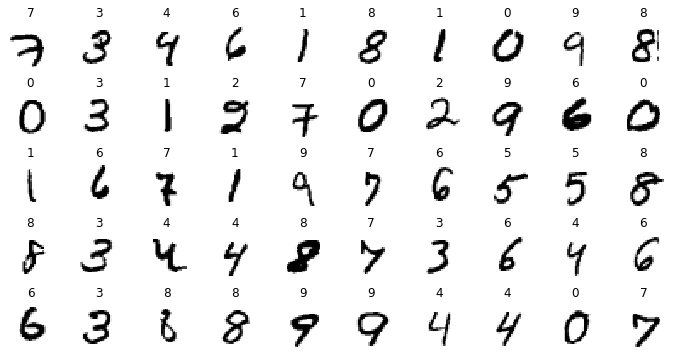

In [4]:
# show examples of the images from mnist
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.2, n_rows*1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols*row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_train[index], cmap='binary', interpolation='nearest')
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

---
# Model

In [5]:
# function to clear session and set seed
def clear_session(seed = 1234):
    keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [6]:
# function plot loss & accuracy
def plot_eval(model_object, history_object):
    model_object.evaluate(X_test, y_test)
    print('')
    pd.DataFrame(history_object.history).plot(figsize=(15, 5))
    plt.title('Loss & Accuracy: Training vs. Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss / Accuracy %')
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

In [7]:
# function to build & compile model
def build_model(learning_rate):
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=X_train.shape[1:]),
        keras.layers.Dense(300, activation='relu'),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
        ])
    model.compile(
        loss = keras.losses.sparse_categorical_crossentropy,
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate),
        metrics = [keras.metrics.sparse_categorical_accuracy]
        )
    model.summary()
    return model

In [8]:
# clear & set session
clear_session(seed = 1234)

In [9]:
# build and compile
model = build_model(learning_rate=1e-3)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


313/313 [==============================] - 1s 2ms/step - loss: 0.2055 - sparse_categorical_accuracy: 0.9409



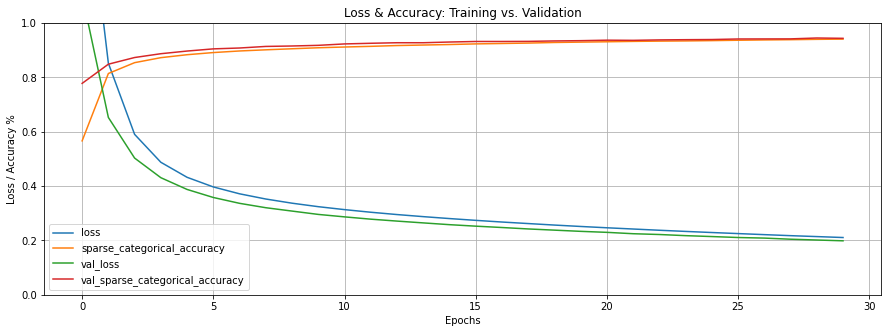

In [10]:
# fit and evaluate
history = model.fit(
    X_train, y_train, epochs=30, verbose=0,
    validation_data=(X_valid, y_valid)
    )

# plot & evaluate
plot_eval(model, history)

---
# Experiment with Increasing Learning Rate

Based on exponentially increasinfg learning rate, testing to see at which point would the learning rate be optimal for this model, the result is around 3e-1.

In [11]:
# create class for increase learning rate
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(
            self.model.optimizer.lr, 
            self.model.optimizer.lr * self.factor
            )

In [12]:
# clear & set session
clear_session(seed = 1234)

In [13]:
# build the same model model
model = build_model(learning_rate=1e-3)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [14]:
# set exponential learning rates
expon_lr = ExponentialLearningRate(factor=1.005)

In [15]:
# 1 epoch per learning rate
history = model.fit(
    X_train, y_train, epochs=1, verbose=2,
    validation_data=(X_valid, y_valid),
    callbacks=[expon_lr])

1719/1719 - 5s - loss: nan - sparse_categorical_accuracy: 0.5916 - val_loss: nan - val_sparse_categorical_accuracy: 0.0958


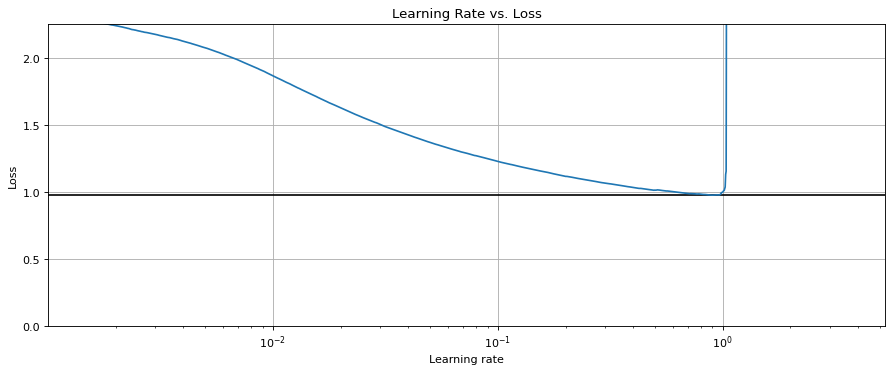

In [16]:
# show learning rates vs loss
plt.figure(figsize=(13.5, 5), dpi=80)
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs. Loss")
plt.show()

---

# Use Best Learning Rate

Use 3e-1 vs. 1e-3.

In [17]:
# clear session and rebuild model
clear_session(seed = 1234)
model_best = build_model(learning_rate=3e-1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


313/313 [==============================] - 1s 2ms/step - loss: 0.0937 - sparse_categorical_accuracy: 0.9842



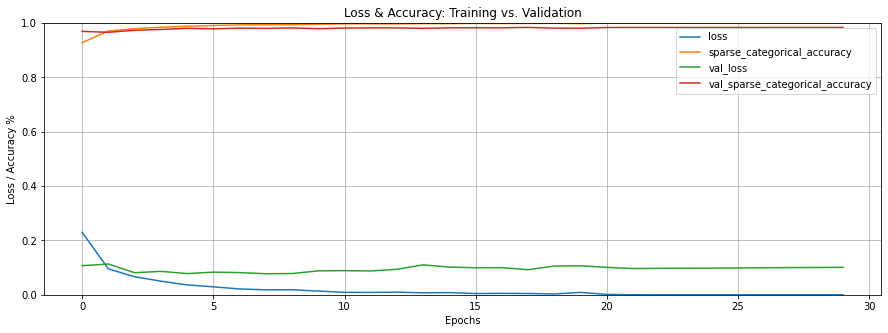

In [18]:
# fit and evaluate
history_best = model_best.fit(
    X_train, y_train, epochs=30, verbose=0,
    validation_data=(X_valid, y_valid)
    )

# plot & evaluate
plot_eval(model_best, history_best)